# Predicting when a company will send it's next marketing email

This project aims to predict when a company will send it's next marketing email. The data comes from [MailCharts](https://www.mailcharts.com/).

Predicting when your competitors will send their next marketing blast allows you to get ahead of the game and send your email before they do.

- Sample data: http://share.mailcharts.com/0b141Z3c1M40
- All data: _coming soon_

In [15]:
# Import libraries and dependencies

from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV
from xgboost import XGBRegressor, plot_tree 
from sklearn.model_selection import train_test_split 


In [16]:
## SQL code to get lag:


In [17]:
# Import the data 
df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(4585, 6)

In [18]:
# df: Take 100 companies

In [19]:
df.head(2) 

,id,company_name,company_id,subject,sent_at,industry_name
0,582036,Ace & Tate,3917,Naughty things to try in 2016...,2016-01-01 11:03:59,other
1,582151,Abercrombie & Fitch,285,The year is yours.,2016-01-01 12:26:09,retail


In [20]:
df= df.sort_values(by=['company_name' , 'sent_at'])

In [21]:
df['prev_company']= df.company_name.shift(1)

In [22]:
df['prev_email']= df.sent_at.shift(1)

In [23]:
prev_email=[]
for i, row in df.iterrows():
    if row[6]== row[1]:
        prev_email.append(row[7])
    else: 
        prev_email.append(None)

In [24]:
df['prev_email_sent_at']=prev_email
df.drop(['prev_email'], axis=1, inplace=True)

In [25]:
df[df.company_name=='Allurez']

,id,company_name,company_id,subject,sent_at,industry_name,prev_company,prev_email_sent_at
5,582980,Allurez,3632,Happy New Year,2016-01-01 21:39:25,NaN,AllModern,None
27,587129,Allurez,3632,Garnet jewelry sale - The birthstone of January,2016-01-05 16:56:02,NaN,Allurez,2016-01-01 21:39:25
64,595382,Allurez,3632,New Year Exclusive - just for you,2016-01-11 16:38:11,NaN,Allurez,2016-01-05 16:56:02
86,600345,Allurez,3632,Ring in the new year,2016-01-14 16:42:01,NaN,Allurez,2016-01-11 16:38:11
113,605620,Allurez,3632,Must see diamond eternity bands,2016-01-18 18:02:12,NaN,Allurez,2016-01-14 16:42:01
126,608508,Allurez,3632,Pearl Perfection!,2016-01-20 15:42:39,NaN,Allurez,2016-01-18 18:02:12
132,609952,Allurez,3632,Shop early for your valentine and save $300!,2016-01-21 14:57:49,NaN,Allurez,2016-01-20 15:42:39
159,614215,Allurez,3632,Need gift ideas? This is for you!,2016-01-24 16:53:23,NaN,Allurez,2016-01-21 14:57:49
169,616035,Allurez,3632,Get the perfect gift with our Valentine's Day ...,2016-01-25 21:32:15,NaN,Allurez,2016-01-24 16:53:23
183,618923,Allurez,3632,You asked for it! Checkout our most popular et...,2016-01-27 17:36:03,NaN,Allurez,2016-01-25 21:32:15


In [26]:
df['company_name']= df.company_name.str.replace(' & ', '')
df['company_name']= df.company_name.str.replace("'" , '')
df['company_name']= df.company_name.str.replace("-" , '')
df['company_name']= df.company_name.str.replace("." , '')

In [27]:
# Add first set of features we need

df['sent_time'] = pd.to_datetime(df.sent_at)
df['hour'] = df.sent_time.apply(lambda x: x.hour)
df['day'] = df.sent_time.apply(lambda x: x.day)
df['month'] = df.sent_time.apply(lambda x: x.month)
df['year'] = df.sent_time.apply(lambda x: x.year)
df['day_of_week'] = df.sent_time.dt.weekday_name 
df['day_of_week_num'] = df.sent_time.dt.weekday 
df['weekend'] = df.day_of_week.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
df["weeknum"] = df.sent_time.dt.weekofyear
df["am_pm"] = df.sent_time.apply(lambda x: 1 if x.strftime('%p') == "AM" else 0)

In [28]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == 0 or b==None:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["delta_in_seconds"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email_sent_at"]), axis=1)

In [54]:
# QA that we only have 1 time_delta with a value of 0

df[df["delta_in_seconds"] == 0]["company_name"].value_counts()

Adorama             2
AbercrombieFitch    1
Allurez             1
1800Flowerscom      1
1000Bulbscom        1
AceEverett          1
AceTate             1
AllModern           1
AGACI               1
10DollarMall        1
Name: company_name, dtype: int64

In [31]:
# Add a few more features which will make it easier to read our time deltas

df["delta_in_hours"] = df["delta_in_seconds"] / 60 / 60
df["delta_in_days"] = df["delta_in_seconds"] / 60 / 60 / 24

In [33]:
# Get company dummies. This will help us calculate each prediction at a company level

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

,1000Bulbscom,10DollarMall,1800Flowerscom,AGACI,AbercrombieFitch,AceEverett,AceTate,Adorama,AllModern,Allurez
6,0,0,1,0,0,0,0,0,0,0
16,0,0,1,0,0,0,0,0,0,0
30,0,0,1,0,0,0,0,0,0,0
36,0,0,1,0,0,0,0,0,0,0
48,0,0,1,0,0,0,0,0,0,0


In [34]:
# Merge both dataframes

df = pd.merge(df, dummy_company, right_index=True, left_index=True)

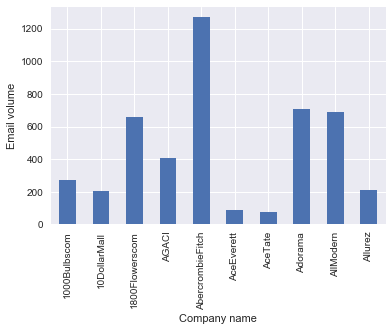

In [35]:
# Visualize  send volume to understand the data a bit better
# Takeaway #1: Email volume varies drastically by company.
# Also, we may have some heavy senders. 1,200+ emails by abercrombie seems extremely high.

email_counts_sum = df.groupby(["company_name"])["delta_in_seconds"].count()
bars = email_counts_sum.plot(kind='bar')
bars.set_ylabel("Email volume")
bars.set_xlabel("Company name")

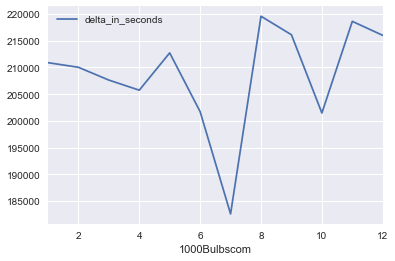

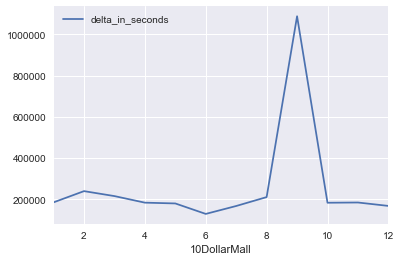

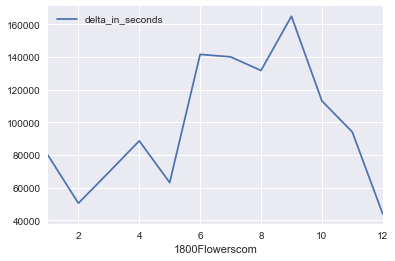

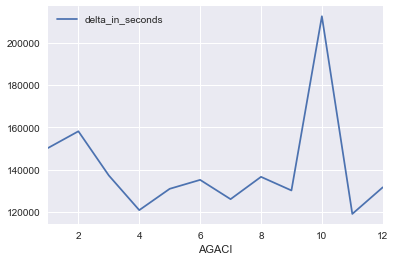

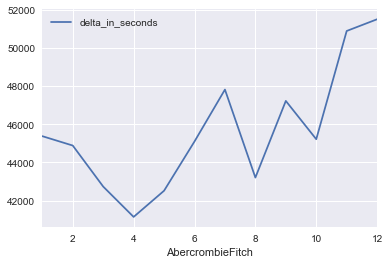

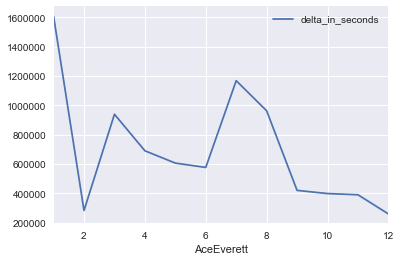

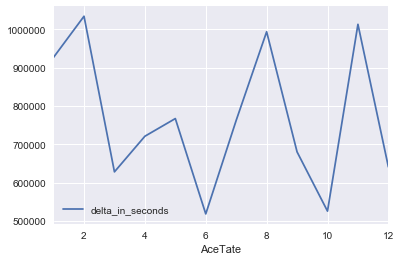

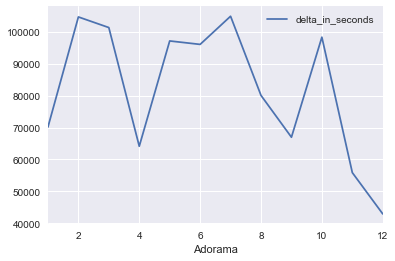

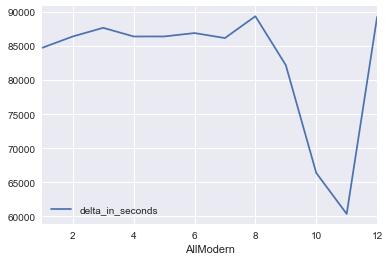

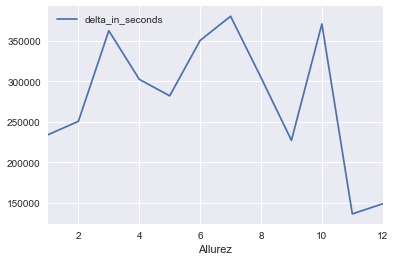

In [36]:
# Let's analyze the sending behavior of these companies
# Takeaway #2: Every company has their own sending behavior!
# Takeaway #3: Seasonality is likely to impact email frequency.
# Note: Spikes == more time in between emails

time_delta_average_by_month = df.groupby(by=['company_name', 'month'])["delta_in_seconds"].mean().reset_index()
c_name = time_delta_average_by_month["company_name"].unique()

for i in c_name:
    company = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].reset_index()
    plot = company.plot(x="month", y="delta_in_seconds")
    plot.set_xlabel(i)


In [37]:
# It's not 100% clear here, but it looks like industry could be a helpful feature to include in our model
# Let's visualize this

df.groupby(["industry_name", "company_name"]).delta_in_seconds.mean().astype(int).reset_index().sort_values("delta_in_seconds")

,industry_name,company_name,delta_in_seconds
6,retail,AbercrombieFitch,44965
3,photography,Adorama,80289
0,e-commerce,AllModern,82759
4,retail,1800Flowerscom,86788
5,retail,AGACI,139194
1,lighting,1000Bulbscom,207690
2,other,AceTate,728605


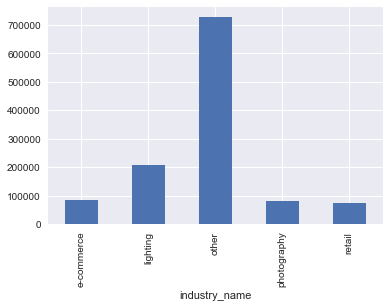

In [38]:
# Visualize the send volume to understand the data a bit better
# Takeaway #4: Consider adding industry as a feature

email_between_time_avg = df.groupby(["industry_name"]).delta_in_seconds.mean()
email_between_time_avg.plot(kind='bar')

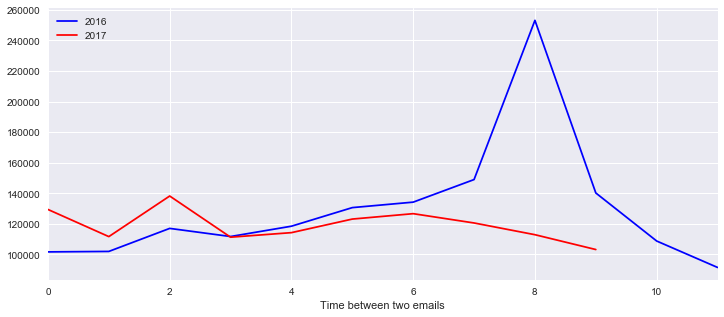

In [39]:
# Let's analyze all of the data by month to see how our 2 years of data compare
# TODO: Make the x-axis start from 1 (January) and not 0

plt.figure(figsize=(12,5))
plt.xlabel('Time between two emails')

df1 = df[df["year"] == 2016].groupby("month").delta_in_seconds.mean().reset_index()
df2 = df[df["year"] == 2017].groupby("month").delta_in_seconds.mean().reset_index()

ax1 = df1.delta_in_seconds.plot(color='blue', label='2016')
ax2 = df2.delta_in_seconds.plot(color='red', label='2017')

h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.show()

# We can see the impact of seasonality

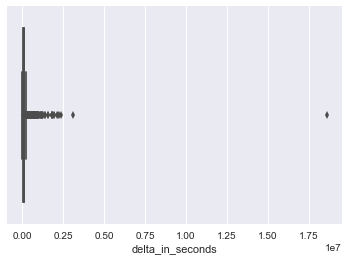

In [40]:
# Next, let's look at the distribution of our email delta

sns.boxplot(x=df["delta_in_seconds"])

# Look at that...! We have some outliers. Let's remove them.

(4585, 31)
(4557, 31)
We removed 28 outliers


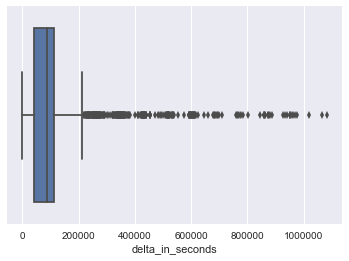

In [41]:
# Remove prev_time_delta outliers

stdev = df.delta_in_seconds.std()
mean = df.delta_in_seconds.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = df[(df.delta_in_seconds >=lower_bound) & (df.delta_in_seconds <= upper_bound)]

print(df.shape)
print(non_outliers.shape)
print("We removed", df.shape[0] - non_outliers.shape[0], "outliers")
sns.boxplot(x=non_outliers["delta_in_seconds"])

In [42]:
# This looks good, let's assign this back to our df variable

df = non_outliers

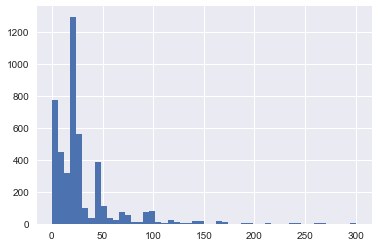

In [43]:
# Let's get a graps of how our data is distributed

df.delta_in_hours.hist(bins = 50)

# Look at that, it's left skewed!

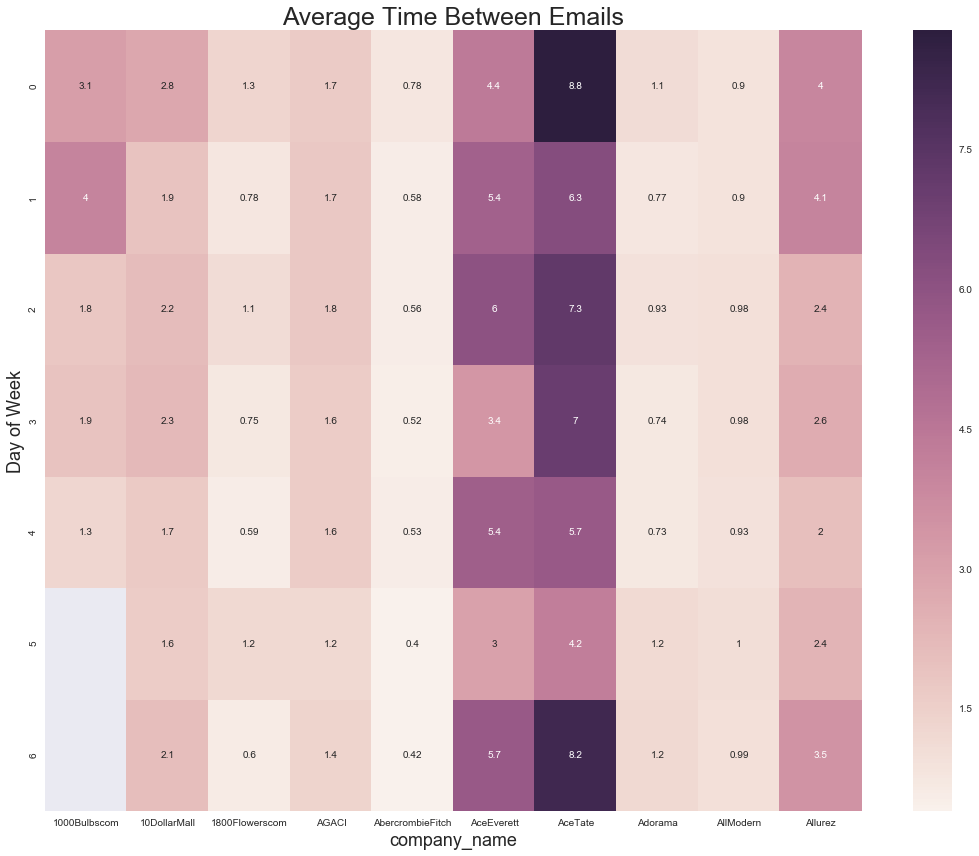

In [44]:
# Let's build a heatmap!

f = plt.figure(1, figsize = (15,12))
pvt = pd.pivot_table(data=df,values='delta_in_days',index='day_of_week_num', columns='company_name')
sns.heatmap(pvt, annot=True)
plt.title('Average Time Between Emails',fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('company_name',fontsize=18)
plt.ylabel('Day of Week',fontsize=18)
plt.tight_layout()

plt.show()

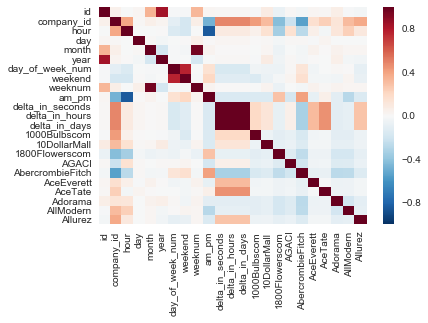

In [45]:
sns.heatmap(df.corr())

In [46]:
# Let's try creating a new feature for retail / not retail

df['retail_ecommerce']=(df.industry_name=='retail') ^ (df.industry_name=='e-commerce')

In [47]:
# Let's analyze seasonality

def season_map(month):
    season=''
    if month <=3:
        season='Spring'
    elif month<=6:
        season='Summer'
    elif month<=9:
        season='Fall'
    else: 
        season='Winter'
    return season

df['season']=df.month.apply(lambda x:season_map(x))
df['season_num'] = pd.Categorical(df.season).codes

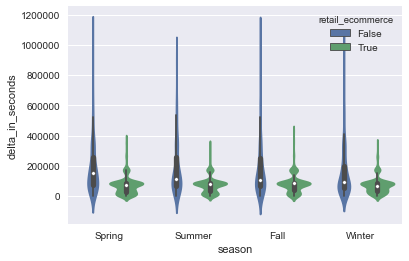

In [48]:
sns.violinplot(x='season', y='delta_in_seconds', data=df, hue='retail_ecommerce' )

## Done with EDA

Features we want:

- Month
- Company
- Industry
- am_pm
- weekend

Models:

- linear regression
- decision tree regressor

In [35]:
# for c in df.columns:
#     print(c)

In [68]:
# The modeling begins

target = df.delta_in_hours
companies = df["company_name"].unique()
features_of_interest = np.append([companies], ['month', 'weeknum', 'am_pm', 'season_num', 'weekend', 'retail_ecommerce'])
features = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3417, 16)
(3417,)
(1140, 16)
(1140,)


In [69]:
# Initialize our fit our model

lg = LinearRegression()
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
y_pred = lg.predict(X_test)
lg.score(X_test, y_test)

0.54260911367519982

In [71]:
# from sklearn import tree
# from IPython.display import Image
# import pydotplus
# import graphviz

# decision_tree = tree.DecisionTreeClassifier(max_depth=4)
# decision_tree.fit(X_train, y_train)

# dot_data = tree.export_graphviz(
#     decision_tree,
#     out_file=None,
#     feature_names=features_of_interest,
#     filled=True
# )
# graph = pydotplus.graph_from_dot_data(dot_data)
# Image(graph.create_png())

In [72]:
# print(decision_tree.score(X_test, y_test))

In [73]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.365320781201


In [74]:
xgr=XGBRegressor()
xgr.fit(X_train, y_train) 
xgr.score(X_test, y_test) 

0.59645311651399546

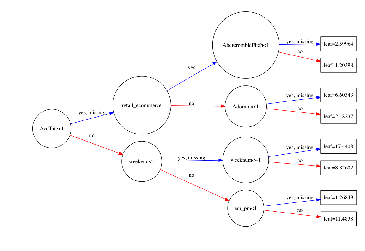

In [76]:
plot_tree(xgr, rankdir='LR' ) 
plt.show()

In [77]:
adr=AdaBoostRegressor()
adr.fit(X_train, y_train) 
adr.score(X_test, y_test) 

0.30816902765842036

In [78]:
gbr=GradientBoostingRegressor()
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)  

0.58183474807499602

In [79]:
#grid search
gbr = GradientBoostingRegressor(max_features= 'sqrt' , loss='ls', n_estimators=50, learning_rate=0.1) 

param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'loss': ['ls', 'lad', 'huber', 'quantile'],
    'learning_rate': [0.1, 0.01, 0.05]
}

CV_gbr = GridSearchCV(estimator=gbr, param_grid=param_grid, cv= 5)
CV_gbr.fit(X_train, y_train)
print(CV_gbr.best_params_)

{'loss': 'ls', 'max_features': 'sqrt', 'learning_rate': 0.05, 'n_estimators': 200}


In [80]:
gbr=GradientBoostingRegressor(max_features= 'sqrt' , loss='ls', n_estimators=200, learning_rate= 0.05)
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)  

0.57459864512302783

In [81]:
#revisit features
target = df.delta_in_seconds
df['industry_num']=pd.Categorical(df.industry_name).codes 
df['subject_promo']=df.subject.str.contains('%') 
companies = df["company_name"].unique()
features_of_interest = np.append([companies], ['month','industry_num','subject_promo', 'day_of_week_num', 'am_pm'])
features = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=42)

In [82]:
gbr=GradientBoostingRegressor(max_features= 'sqrt' , loss='ls', n_estimators=1000, learning_rate= 0.05)
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)  

0.59846626738563291

In [83]:
xgr=XGBRegressor()
xgr.fit(X_train, y_train) 
xgr.score(X_test, y_test) 

0.59912953381395861

In [85]:
#stacking models 
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR


# Initializing models

lr = LinearRegression()
svr_lin = SVR(kernel='linear')
ridge = Ridge(random_state=1)
svr_rbf = SVR(kernel='rbf')
gbr=GradientBoostingRegressor(max_features= 'sqrt' , loss='ls', n_estimators=1000, learning_rate= 0.05)
xgr=XGBRegressor()
adr=AdaBoostRegressor() 

stregr = StackingRegressor(regressors=[lr, adr, decision_tree], 
                           meta_regressor=gbr)

# Training the stacking

stregr.fit(X_train, y_train)
stregr.predict(X_test)

# Evaluate and visualize the fit

# print("Mean Squared Error: %.4f"
#       % np.mean((stregr.predict(X_test) - y_test) ** 2))
print('Score: %.4f' % stregr.score(X_test, y_test)) 

Score: 0.5404


In [93]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.linear_model import Lasso

# # Initializing models

# lr = LinearRegression()
# svr_lin = SVR(kernel='linear')
# ridge = Ridge(random_state=1)
# lasso = Lasso(random_state=1)
# svr_rbf = SVR(kernel='rbf')
# regressors = [svr_lin, lr, ridge, lasso]
# stregr = StackingRegressor(regressors=regressors, 
#                            meta_regressor=svr_rbf)

# params = {'lasso__alpha': [0.1, 1.0, 10.0],
#           'ridge__alpha': [0.1, 1.0, 10.0],
#           'svr__C': [0.1, 1.0, 10.0],
#           'meta-svr__C': [0.1, 1.0, 10.0, 100.0],
#           'meta-svr__gamma': [0.1, 1.0, 10.0]}

# grid = GridSearchCV(estimator=stregr, 
#                     param_grid=params, 
#                     cv=5,
#                     refit=True)

# grid.fit(X_train, y_train)

# for params, mean_score, scores in grid.grid_scores_:
#         print("%0.3f +/- %0.2f %r"
#               % (mean_score, scores.std() / 2.0, params))

## Benchmark on average email in between time by company

In [94]:
#let's use GradientBoosting  
gbr=GradientBoostingRegressor()
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)  

0.60289231528309717

In [95]:
df["company_name"].unique()

array(['1800Flowerscom', '1000Bulbscom', '10DollarMall', 'AGACI',
       'AbercrombieFitch', 'AceEverett', 'AceTate', 'Adorama', 'AllModern',
       'Allurez'], dtype=object)

In [96]:
#benchmark on avg 
benchmark_company = "AllModern"
benchmark_mean = df[df[benchmark_company] == 1].delta_in_hours.mean()

In [97]:
#our model 's abs error 
abs(y_test[X_test[benchmark_company]==1 ]- gbr.predict(X_test[X_test[benchmark_company]==1])).mean()

13140.927406910117

In [98]:
#benchmark's abs error 
abs(y_test[X_test[benchmark_company]==1 ]-  benchmark_mean).mean()

80918.43107178532

In [99]:
#lift is the diff/benchmark 